# Multi Agent Collaboration Network 

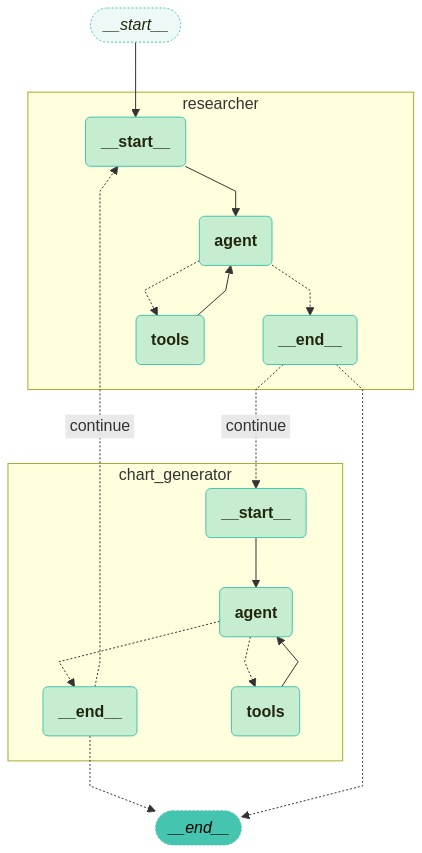

## Overview

In this tutorial, we'll explore how to implement a **multi-agent network** using LangGraph.  
A multi-agent network is an architecture that leverages a "divide-and-conquer" approach by breaking down complex tasks into smaller, specialized agents. 

This helps resolve the inefficiencies of a single agent managing numerous tools, allowing each agent to focus on its area of expertise and solve problems effectively.

Inspired by the [AutoGen paper](https://arxiv.org/abs/2308.08155), this tutorial walks you through the process of building such multi-agent networks with LangGraph step-by-step. 

![network](./assets/17-langgraph-multi-agent-network.png)

**Key Topics Covered**

- **Defining States** : How to define graph states and manage the state information required for each agent's actions  
- **Defining Tools** : How to specify tools that agents can use and add them as nodes  
- **Creating Agents** : How to define agents and set them as nodes in a LangGraph network  
- **Defining Agent Nodes** : How to define specialized agents as nodes  
- **Defining Tool Nodes** : How to define tools as nodes and enable agents to utilize them  
- **Defining Edge Logic** : How to set branching logic that directs agents or tools based on the results of an agent’s task  
- **Graph Definition** : How to combine agents, tools, states, and edge logic into a cohesive graph  
- **Running the Graph** : How to execute the graph and perform real-world tasks with the defined setup  

Let's get started!


### References

- [Concept of Multi Agent Network LangGraph](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network)  
- [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)  
----

## Environment Setup

In [1]:
# import getenv
import os
import getpass
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI

## Why Do We Use Multi-Agent Networks?

A single agent can be efficient when working within a specific domain and using a limited number of tools. However, as the number of tools increases, several challenges arise:  
1. The logic for managing tools becomes increasingly complex.  
2. The amount of information the agent needs to process at once grows, leading to inefficiencies.

By adopting a "divide-and-conquer" approach, each agent focuses on a specific task or area of expertise, while the overall workload is distributed across a network.  
Each agent handles what it does best and delegates tasks to other specialized agents or utilizes tools effectively when needed.

This structure enhances efficiency and simplifies the management of complex workflows.

## Defining States

`messages` is a list of messages shared between agents, and `sender` refers to the sender of the most recent message.

In [2]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage


# Defining state
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # a list of messages shared between agents
    sender: Annotated[str, "The sender of the last message"]

## Defining Tools

Here, we define a few tools that agents will use in the network:

- `TavilySearch` : A tool for searching information on the internet. It is used by the `research_agent` to find the necessary data.  
- `PythonREPL` : A tool for executing Python code. It is used by the `chart_agent` to create charts.  

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Defining tavily web search tool
tavily_tool = TavilySearchResults(max_results=5)

# Defining a tool for executing python code
python_repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Creating Agents

Here’s an example of how to create agents. In this tutorial, we’ll use the Research Agent and the Chart Generator Agent to build a multi-agent network.


First, define the LLM model and a common system prompt to be used for the agents.

In [4]:
from langchain_openai import AzureChatOpenAI

# Defining LLM
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
)

In [5]:
# Defining common system prompt
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

### Research Agent

Create an agent that performs research using the `TavilySearch` tool. This agent is used to gather the required information.

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState


research_agent_system_prompt = """
You can only do research. You are working with a chart generator colleague.
"""

# Create Research Agent
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(research_agent_system_prompt),
)


# Defining Research Agent Node
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        "messages": [last_message],
    }

### Chart Generator Agent

Create an agent that generates charts using the `PythonREPL` tool. This agent is used to create charts.

In [7]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.
"""

# Create Chart Generator Agent
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=make_system_prompt(chart_generator_system_prompt),
)


# Defining Chart Generator Agent Node
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        "messages": [last_message],
    }

## Building a Multi-Agent Graph

This workflow uses LangGraph to build a **multi-agent system** where agents collaborate dynamically. 

The `router` decides the next step by analyzing messages—either continuing to the next node or ending the workflow. 

Each node, like `researcher` and `chart_generator`, is connected using **conditional edges** that determine the workflow’s flow based on the router's logic. The system starts with the `researcher` and alternates between agents until a "FINAL ANSWER" is reached.

In [8]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# Defining Router
def router(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"


# Building a multi-agent network workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())

Let's take a look at the graph we’ve created by visualizing it!

In [9]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app, xray=True)

[ERROR] Visualize Graph Error: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


## Running the Agents

Now it’s time to execute the multi-agent workflow we’ve built! 

Using the `RunnableConfig`, we set up necessary configurations like recursion limits and unique thread IDs. 

Then, we input a query and invoke the graph, allowing the agents to collaborate and generate results based on the workflow.


Here’s an example of code that visualizes the global per capita GDP from 2015 to 2024. If you’re curious about something else, try changing the query and see how well the agents handle it!



🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ZmJrMTm1oVQaflRPe5LxSRZV)
 Call ID: call_ZmJrMTm1oVQaflRPe5LxSRZV
  Args:
    query: historical and projected global per capita GDP from 2015 to 2024 data

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_mFkojWqVdR266zBaKMOCSMO9)
 Call ID: call_mFkojWqVdR266zBaKMOCSMO9
  Args:
    query: global per capita GDP historical data 2015 to 2024 source
  tavily_search_results_json (call_t6xs6jYrjdnZI0DjaOKkUP3Q)
 Call ID: call_t6xs6jYrjdnZI0DjaOKkUP3Q
  Args:
    query: IMF World Economic Outlook October 2024 GDP per capita

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
===================

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (call_41052qVL9l3DlQGyMlt3A1xn)
 Call ID: call_41052qVL9l3DlQGyMlt3A1xn
  Args:
    code: import matplotlib.pyplot as plt

# Data for Global per capita GDP (2015-2024, in USD)
years = list(range(2015, 2025))
gdp_per_capita = [10100, 10500, 11050, 11500, 12030, 12500, 13100, 13550, 13900, 14500]

plt.figure(figsize=(10, 6))
plt.plot(years, gdp_per_capita, marker='o', label='GDP per capita ($)')
plt.title('Global GDP per Capita (2015 - 2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP per Capita (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.show()


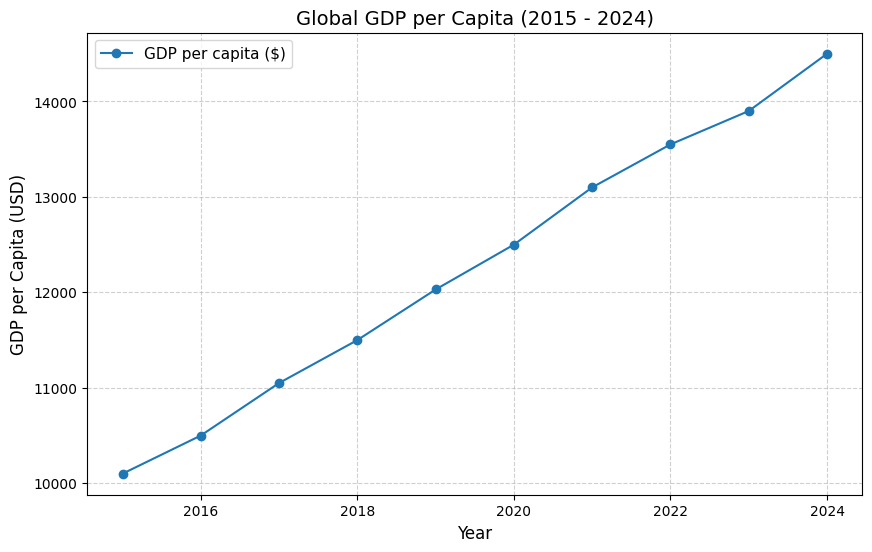


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

FINAL ANSWER: The visualization depicts global GDP per capita in USD from 2015 to 2024, displaying an upward trend over the years. Use the chart for reference to see how GDP per capita has evolved during the decade.

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

FINAL ANSWER: The visualization depicts global GDP per capita in USD from 2015 to 2024, displaying an upward trend over the years. Use the chart for reference to see how GDP per capita has evolved during the decade.


In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph, random_uuid

# set up config (recursion_limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# input query
inputs = {
    "messages": [
        HumanMessage(
            content="."Visualize the global per capita GDP from 2015 to 2024
        )
    ],
}

# invoke graph
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_PDMMhvDHYypJMAxGJujd6zml)
 Call ID: call_PDMMhvDHYypJMAxGJujd6zml
  Args:
    query: MSFT historical stock performance 2015 to 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_5TUIzoGw6XkLDsji3dM0bbrG)
 Call ID: call_5TUIzoGw6XkLDsji3dM0bbrG
  Args:
    query: MSFT stock yearly average prices and yearly close from 2015 to 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ToBs4D997ox2sLUOYeiNngOi)
 Call ID: call_ToBs4D997ox2sLUOYeiNngOi
  Args:
    q

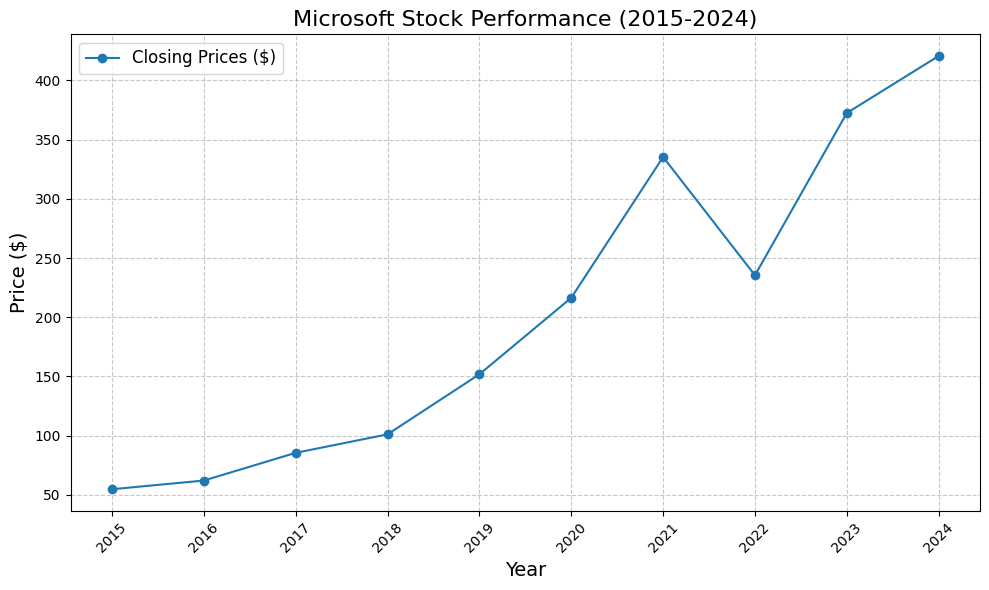


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

FINAL ANSWER: The visualization of Microsoft's stock performance from 2015 to 2024 has been successfully generated. It exhibits a steady increase in closing prices over time, despite fluctuations, with notable peaks in recent years. If further adjustments or analysis are needed, please let us know!

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

FINAL ANSWER: The visualization of Microsoft's stock performance from 2015 to 2024 has been successfully generated. It exhibits a steady increase in closing prices over time, despite fluctuations, with notable peaks in recent years. If further adjustments or analysis are needed, please let us know!


In [11]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph, random_uuid

# set up config (recursion_limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# input query
inputs = {
    "messages": [
        HumanMessage(
            content="Visualize the performance of MSFT stock from 2015 to 2024."
        )
    ],
}

# invoke graph
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])